# Winner Takes All

This notebook trains a sparse autoencoder which will be used as the dictionary learning tool for creating positive and negative pairs. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer, Lambda
from keras.layers.convolutional import Convolution1D, MaxPooling1D, UpSampling1D, Conv1D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.constraints import non_neg

plt.style.use('ggplot')

Using TensorFlow backend.


In [3]:
# read the ICE plots data

X, x_ice = np.load("artifacts/data_ice.npy")
X = X.reshape(*X.shape,1)
print("Shape of the data: ", X.shape)

Shape of the data:  (100, 10, 1)


Text(0, 0.5, 'Amplitude')

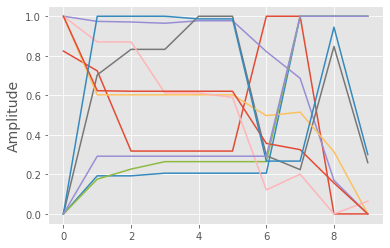

In [4]:
# Samples of the data

_ = plt.plot(X.squeeze().T[:, :10])
plt.ylabel('Amplitude', fontsize=14)

In [5]:
# hyperparameters

nb_epoch = 200

n_rows, n_cols = X.shape[1], X.shape[2]

# nb_filters would be the number of dictionary atoms
nb_filters = 20 # number of filters in Conv1D layers
nb_conv = 5 # size of the convolutional kernels in encoder
code_size = 5 # size of the convolutional kernels in decoder => this will be the size of the dictionary atoms

# using these values we will have 20 atoms with size of 5 => D \in R^{20 \times 5}

In [6]:
# winner takes all layer: only keep the highest value

def wtall(X):
    M = K.max(X, axis=(1), keepdims=True)
    R = K.switch(K.equal(X, M), X, K.zeros_like(X))
    return R

In [7]:
# encoder definition

enc = Sequential()
enc.add(Conv1D(nb_filters, (nb_conv), activation='relu', padding='same', input_shape=(n_rows, n_cols)))
enc.add(Conv1D(nb_filters, (nb_conv), activation='relu', padding='same')) 
pool_shape = enc.output_shape
enc.add(Lambda(function=wtall, output_shape=pool_shape[1:]))

enc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 20)            120       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 20)            2020      
_________________________________________________________________
lambda_1 (Lambda)            (None, 10, 20)            0         
Total params: 2,140
Trainable params: 2,140
Non-trainable params: 0
_________________________________________________________________


In [8]:
# decoder definition

dec = Sequential()
dec.add(Conv1D(1, (code_size), strides=1, padding='same',input_shape=pool_shape[1:], kernel_constraint=non_neg()))
dec.add(Flatten())
dec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 1)             101       
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Autoencoder with encoder and decoder

model = Sequential()
model.add(enc)
model.add(dec)

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 10, 20)            2140      
_________________________________________________________________
sequential_2 (Sequential)    (None, 10)                101       
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [10]:
# training the model

history = model.fit(X, X.reshape((-1, X.shape[1])), batch_size=32, epochs=500, verbose=0 )

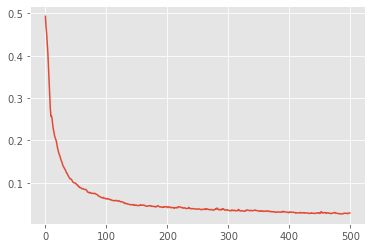

In [11]:
# Training curve

plt.plot(history.history['loss'])

(5, 20, 1)


Text(0, 0.5, 'Decoder Kernel Weights')

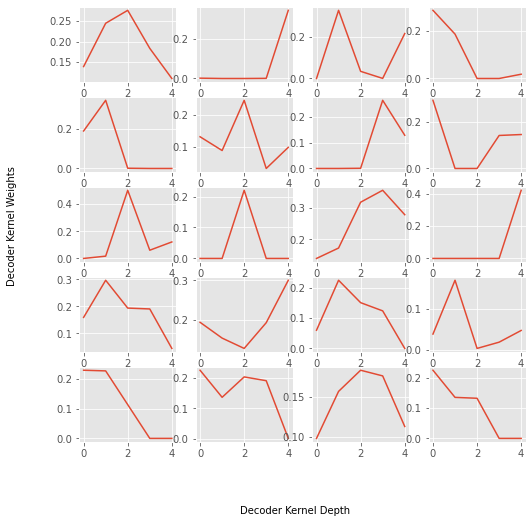

In [12]:
# The learned dictionaries

W = np.asarray(K.eval(dec.layers[0].weights[0]))

print(W.shape)
fig = plt.figure(figsize=(8,8))
for i in range(min(20,nb_filters)):
    plt.subplot(5,4,i+1)
    plt.plot(W[:,i,0])


fig.text(0.5, 0, 'Decoder Kernel Depth', ha='center')
fig.text(0, 0.5, 'Decoder Kernel Weights', va='center', rotation='vertical')

In [13]:
# enc.save('eartifacts/ncoder.h5')
# dec.save('artifacts/decoder.h5')

In [14]:
# create the negative pairs

def negative_sample(x, enc, dec):
    
    enc_x0 = enc.predict(x.reshape(1,10,1))
    enc_x1 = np.zeros_like(enc_x0)
    
    std = np.std(enc_x0[enc_x0>0])
    
    ind0 = np.where(enc_x0 > std/2)
    ind1 = np.where(enc_x0 <= std/2)

    ind_select = np.zeros_like(ind0)
    for i in range(len(ind1)): 
        ind_tmp = ind1[i].copy()
        np.random.shuffle(ind_tmp)
        ind_tmp = ind_tmp[:len(ind0[0])]
        ind_select[i, :] = ind_tmp

    for j in range(len(ind0[0])):
        enc_x1[ind_select[0][j], ind_select[1][j], ind_select[2][j]] = enc_x0[ind0[0][j], ind0[1][j], ind0[2][j]]
    
    xr = dec.predict(enc_x1.reshape(1,10,-1)).reshape(10,1)
    
    xr = (xr-xr.min())/(xr.max()-xr.min())
    
    return xr, 1-x.reshape(1,10,1)

Text(0, 0.5, 'Amplitude')

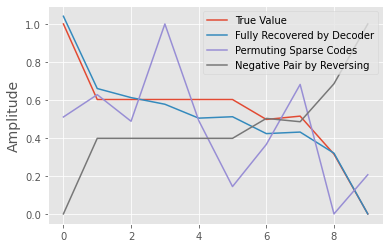

In [15]:
# plotting some of the negative pairs

ind = np.random.randint(0,100,size=(1))[0]
plt.plot(X[ind], label="True Value")


enc_x0 = enc.predict(X[ind].reshape(1,10,1))
enc_x0 = enc_x0[0].reshape(1,10,nb_filters)
xr = dec.predict(enc_x0)
xr = xr.reshape((10))
plt.plot(xr, label="Fully Recovered by Decoder")

x1, x2 = negative_sample(X[ind], enc, dec)

    
xr = x1.reshape((10))
plt.plot(xr, label="Permuting Sparse Codes")


xr = x2.reshape((10))
plt.plot(xr, label="Negative Pair by Reversing")

plt.legend()
plt.ylabel("Amplitude", fontsize=14)

In [16]:
# Create the posirive pairs

def positive_sample(x, enc, dec):
    
    enc_x0 = enc.predict(x.reshape(1,10,1))
    
    enc_x1 = enc_x0
    std = np.std(enc_x0[enc_x0>0])
    
    mask = np.zeros_like(enc_x0)
    mask[np.ix_(*np.where(enc_x0>0))]=1
    
    noise = np.random.randn() * std/5 * mask
    xr = dec.predict(enc_x1 + np.abs(noise))
    xr1 = xr.reshape(10, 1)

    xr = dec.predict(enc_x0 * np.abs(enc_x0)>std)
    xr2 = xr.reshape(10, 1)
    
    xr1 = (xr1-xr1.min())/(xr1.max()-xr1.min())
    xr2 = (xr2-xr2.min())/(xr2.max()-xr2.min())
    
    return xr1, xr2

Text(0, 0.5, 'Amplitude')

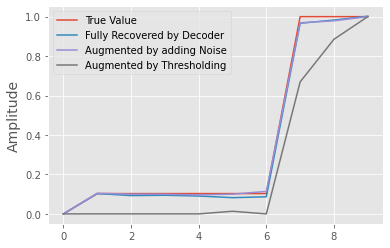

In [17]:
# examples of the positive pairs

ind = np.random.randint(0,100,size=(1))[0]
plt.plot(X[ind], label="True Value")


enc_x0 = enc.predict(X[ind].reshape(1,10,1))
enc_x0 = enc_x0[0].reshape(1,10,nb_filters)
xr = dec.predict(enc_x0)
xr = xr.reshape((10))
plt.plot(xr, label="Fully Recovered by Decoder")

x1, x2 = positive_sample(X[ind], enc, dec)
xr = x1.reshape((10))
plt.plot(xr, label="Augmented by adding Noise")
xr = x2.reshape((10))
plt.plot(xr, label="Augmented by Thresholding")


plt.legend()
plt.ylabel("Amplitude", fontsize=14)